In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, YearLocator
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.models import save_model


In [31]:
train = pd.read_csv('DailyDelhiClimateTrain.csv')
test = pd.read_csv('DailyDelhiClimateTest.csv')

In [33]:
print(f"train_shape: {train.shape}")
print(f"test_shape: {test.shape}")

train_shape: (1462, 5)
test_shape: (114, 5)


In [35]:
WINDOW_SIZE = 5

In [37]:
def data_to_input_and_output(data):

    input_data = []
    output_data = []
    for index in range(0, len(data) - WINDOW_SIZE):
        input_sample = data['meantemp'][index:index + WINDOW_SIZE]
        output_sample = data['meantemp'][index + WINDOW_SIZE]

        input_data.append(input_sample)
        output_data.append(output_sample)

    return np.array(input_data), np.array(output_data)

In [39]:
train_input, train_output = data_to_input_and_output(train)
test_input, test_output = data_to_input_and_output(test)

In [47]:
def train_neural_network(X, y, epochs=7, learning_rate=0.005):

    model = Sequential()
    model.add(InputLayer((WINDOW_SIZE, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    check_point = ModelCheckpoint('model_checkpoint.keras', save_best_only=True, monitor='loss')

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])

    model.fit(X, y, epochs=epochs, callbacks=[check_point])
    return model

In [49]:
model = train_neural_network(train_input, train_output)

Epoch 1/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 347.1882 - root_mean_squared_error: 18.2241
Epoch 2/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 44.7882 - root_mean_squared_error: 6.6878
Epoch 3/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 13.2003 - root_mean_squared_error: 3.5955
Epoch 4/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.3097 - root_mean_squared_error: 1.8176
Epoch 5/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6817 - root_mean_squared_error: 1.6361
Epoch 6/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.2164 - root_mean_squared_error: 1.7898
Epoch 7/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.5781 - root_mean_squared_error: 1.6039


In [55]:
model.save('model.keras')

In [57]:
train_pred = model.predict(train_input)
test_pred = model.predict(test_input)

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [63]:
def plot_predictions(pred, y_true, label, period):
    period = pd.to_datetime(period)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(period, y_true, label='True Values', marker='o', color='black')
    plt.plot(period, pred, label='Predictions', marker='o', color='red')

    plt.xlabel('Date')
    plt.ylabel('Mean temperature')
    plt.title(label)
    plt.legend()

    if label == "Train Data":
        # Format X-axis to show only years
        plt.gca().xaxis.set_major_locator(YearLocator())
        plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
    elif label == "Test Data":
        # Format X-axis to show only months
        plt.gca().xaxis.set_major_locator(MonthLocator())
        plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))

    # Rotate x-axis labels for better visibility
    plt.gcf().autofmt_xdate()
    
    plt.show()

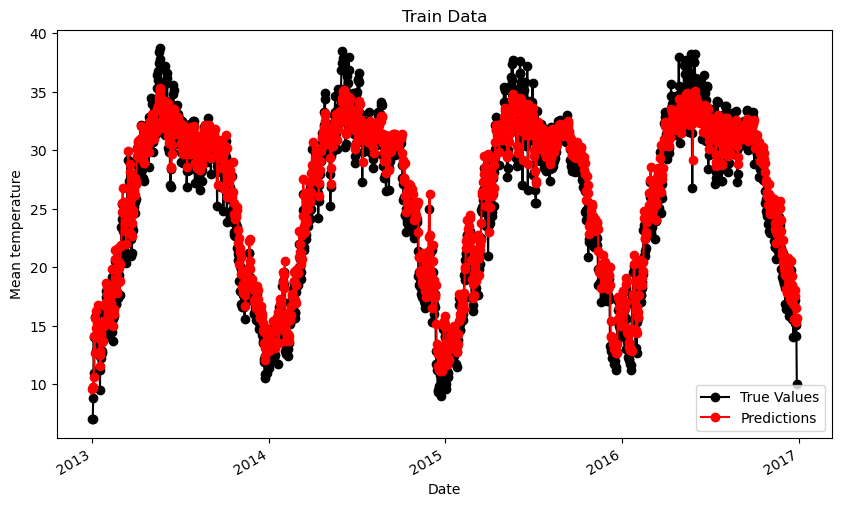

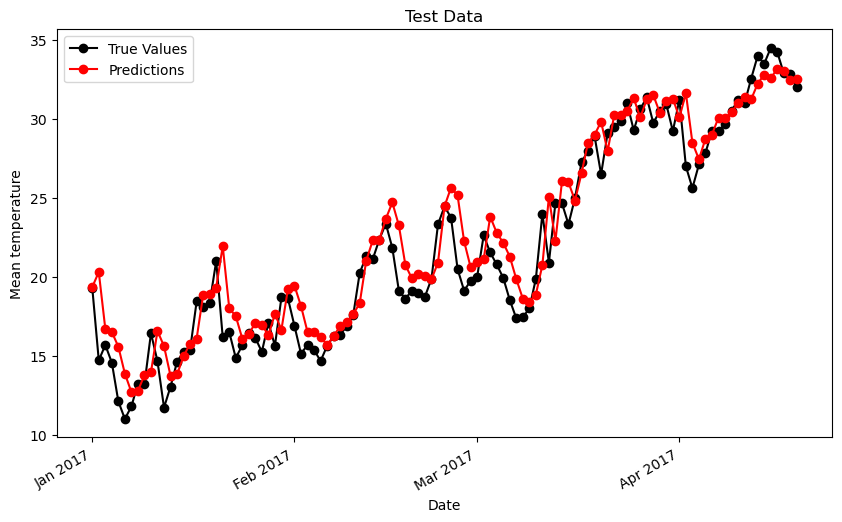

In [65]:
train_period = train[0:len(train) - WINDOW_SIZE]['date']
test_period = test[0:len(test) - WINDOW_SIZE]['date']

plot_predictions(train_pred, train_output, 'Train Data', train_period)
plot_predictions(test_pred, test_output, 'Test Data', test_period)